In [2]:
from PyEcoLib.simulator import Simulator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import kurtosis, skew
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

%matplotlib inline

In [37]:
ncells = 400
doubling_time = 20 #min
gr = np.log(2)/doubling_time 
mean_size = 4 # micron
div_steps = 20

tmax = 400 #min
sample_time = 0.004 #min, 5000 frames per gen

In [38]:
# collect some initial size distribution
sim = Simulator(ncells=1, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=None)
sim.szdyn(tmax=tmax, sample_time=tmax/ncells, nameCRM = "./data/dataV0.csv")
data = pd.read_csv("./data/dataV0.csv")
data.head(10)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


,time,Cell1
0,0.0,4.0000
1,1.0,4.1587
2,2.0,4.3238
3,3.0,4.4954
4,4.0,4.6738
5,5.0,4.8594
6,6.0,5.0522
7,7.0,5.2528
8,8.0,5.4613
9,9.0,5.6780


401


(array([34., 67., 77., 68., 59., 43., 27., 16.,  7.,  3.]),
 array([3.0434 , 3.67008, 4.29676, 4.92344, 5.55012, 6.1768 , 6.80348,
        7.43016, 8.05684, 8.68352, 9.3102 ]),
 <BarContainer object of 10 artists>)

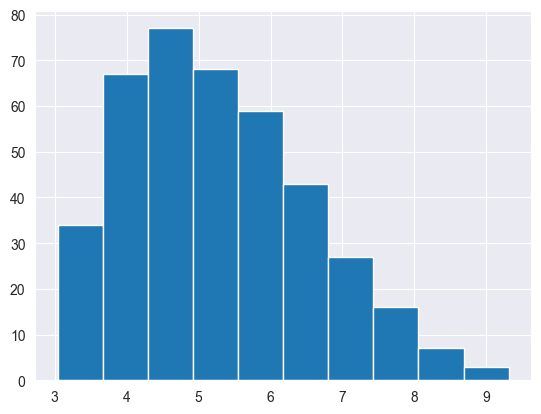

In [39]:
initial_size = data['Cell1'].to_numpy()
print(len(initial_size))
plt.hist(initial_size)

In [40]:
start = time.time()
sim = Simulator(ncells=ncells, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=initial_size[1:])
sim.szdyn(tmax=tmax, sample_time=sample_time, nameCRM = "./data/dataAdder.csv")
print('It took', int(time.time()-start), 'seconds.')

Cells initialized
Cells initialized
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
It took 101 seconds.


In [41]:
data1 = pd.read_csv("./data/dataAdder.csv")
data1.head(10)

,time,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,...,Cell391,Cell392,Cell393,Cell394,Cell395,Cell396,Cell397,Cell398,Cell399,Cell400
0,0.000,4.1586,4.3238,4.4954,4.6738,4.8594,5.0522,5.2528,5.4612,5.6780,...,7.0578,7.3343,7.6217,3.9058,4.0583,4.2168,4.3815,4.5526,4.7304,4.9151
1,0.004,4.1592,4.3244,4.4959,4.6744,4.8600,5.0530,5.2535,5.4619,5.6787,...,7.0589,7.3351,7.6227,3.9062,4.0588,4.2173,4.3821,4.5533,4.7310,4.9157
2,0.008,4.1598,4.3251,4.4964,4.6751,4.8606,5.0538,5.2542,5.4625,5.6795,...,7.0600,7.3359,7.6237,3.9067,4.0593,4.2178,4.3827,4.5540,4.7316,4.9164
3,0.012,4.1604,4.3257,4.4970,4.6757,4.8613,5.0546,5.2549,5.4631,5.6803,...,7.0611,7.3368,7.6248,3.9072,4.0599,4.2183,4.3834,4.5547,4.7323,4.9170
4,0.016,4.1609,4.3264,4.4975,4.6764,4.8619,5.0554,5.2556,5.4637,5.6810,...,7.0623,7.3376,7.6258,3.9077,4.0604,4.2189,4.3840,4.5555,4.7329,4.9177
5,0.020,4.1615,4.3270,4.4981,4.6771,4.8625,5.0562,5.2563,5.4643,5.6818,...,7.0634,7.3385,7.6269,3.9082,4.0610,4.2194,4.3846,4.5562,4.7335,4.9184
6,0.024,4.1621,4.3277,4.4986,4.6777,4.8632,5.0570,5.2571,5.4649,5.6826,...,7.0645,7.3394,7.6279,3.9086,4.0615,4.2199,4.3853,4.5569,4.7342,4.9190
7,0.028,4.1626,4.3283,4.4991,4.6784,4.8638,5.0579,5.2578,5.4655,5.6833,...,7.0657,7.3402,7.6290,3.9091,4.0621,4.2205,4.3859,4.5577,4.7348,4.9197
8,0.032,4.1632,4.3290,4.4997,4.6790,4.8644,5.0587,5.2585,5.4661,5.6841,...,7.0668,7.3411,7.6300,3.9096,4.0626,4.2210,4.3865,4.5584,4.7354,4.9204
9,0.036,4.1638,4.3296,4.5002,4.6797,4.8651,5.0595,5.2592,5.4667,5.6849,...,7.0679,7.3419,7.6310,3.9101,4.0632,4.2215,4.3872,4.5591,4.7361,4.9210


In [42]:
timearray=data1.time.unique()
print(timearray)
test = data1.iloc[:, 0]
test

[0.00000e+00 4.00000e-03 8.00000e-03 ... 3.99992e+02 3.99996e+02
 4.00000e+02]


0           0.000
1           0.004
2           0.008
3           0.012
4           0.016
           ...   
99996     399.984
99997     399.988
99998     399.992
99999     399.996
100000    400.000
Name: time, Length: 100001, dtype: float64

In [43]:
# data1_m = data1.melt('time', var_name='cols', value_name='cells')
# sns.lineplot(data=data1_m, x="time", y="cells", hue='cols')
# plt.show()

In [44]:
def find_division(data, i, height=None, threshold=None, distance=None):
    idx, _ = scipy.signal.find_peaks(data.iloc[:, i], height=height, threshold=threshold, distance=distance)
    return idx

def down_sample(data, n):
    samples = data.iloc[::n, :].reset_index(drop=True)
    return samples

def get_prop(data, i):
    idx = find_division(data, i)
    div_times = np.diff(data.iloc[:, 0].to_numpy()[idx])
    return div_times

def xunder(ts, thresh, filt=True):
    if filt:
        # x = gaussian_filter1d(ts, 5) < thresh
        x = savgol_filter(ts, 10, 1) < thresh
    else:
        x = ts < thresh
    return x.argmin() if x.any() else 0

In [45]:
# ds_1 = down_sample(data1, 2500)
# ds1_m = ds_1.melt('time', var_name='cols', value_name='cells')
# sns.lineplot(data=ds1_m, x="time", y="cells", hue='cols')
# plt.show()

[15.136 17.348 22.136 24.396 11.284 18.876 25.148 10.724 26.792 20.44
 16.808 15.572 21.84  21.62  16.48  19.172 16.66  22.776 20.14 ]


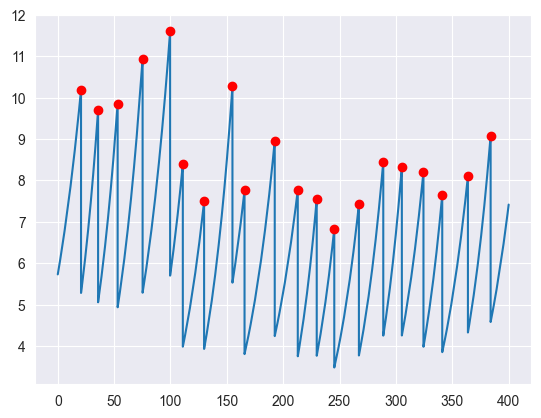

In [46]:
cell_num = 150
idx = find_division(data1, cell_num)
plt.plot(data1.iloc[:, 0], data1.iloc[:, cell_num])
plt.plot(data1.iloc[:, 0].to_numpy()[idx], data1.iloc[:, cell_num].to_numpy()[idx], 'ro')
print(get_prop(data1, cell_num))
plt.show()

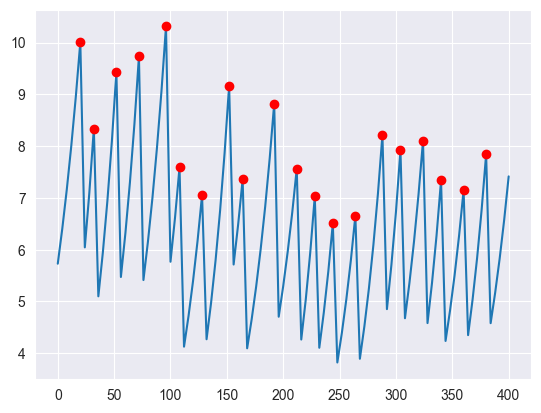

In [68]:
cell_num = 150
ds = down_sample(data1, n=1000) # 4min interval
idx = find_division(ds, cell_num)
plt.plot(ds.iloc[:, 0], ds.iloc[:, cell_num])
plt.plot(ds.iloc[:, 0].to_numpy()[idx], ds.iloc[:, cell_num].to_numpy()[idx], 'ro')
plt.show()

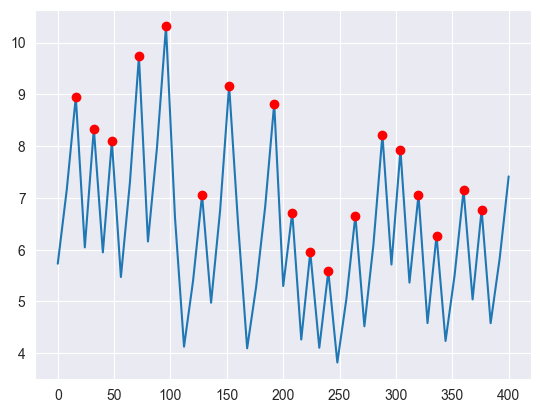

In [69]:
plt.show()
cell_num = 150
ds = down_sample(data1, n=2000)  # 8min interval
idx = find_division(ds, cell_num)
plt.plot(ds.iloc[:, 0], ds.iloc[:, cell_num])
plt.plot(ds.iloc[:, 0].to_numpy()[idx], ds.iloc[:, cell_num].to_numpy()[idx], 'ro')
plt.show()

0.943473296423795


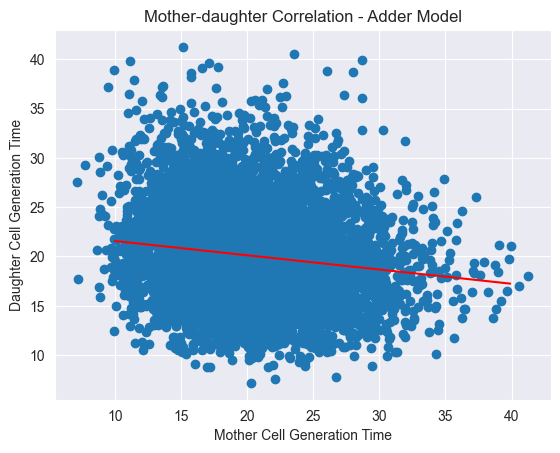

In [58]:
mothers_tau1 = []
daughters_tau1 = []
for i in range(ncells):
    true_div_times = get_prop(data1, i+1) 
    tmother = true_div_times[:-1]
    tdaughter = true_div_times[1:]
    mothers_tau1.extend(tmother)
    daughters_tau1.extend(tdaughter)
# slope1, _, __, ___, ____ = linregress(mothers_tau1, daughters_tau1)
slope1, _, __, ___, ____ = linregress(daughters_tau1, mothers_tau1)
true_c = slope1

test_x = np.arange(10, 40, 0.1)
plt.title("Mother-daughter Correlation - Adder Model")
plt.ylabel("Daughter Cell Generation Time")
plt.xlabel("Mother Cell Generation Time")
plt.plot(mothers_tau1, daughters_tau1, 'o')
plt.plot(test_x, slope1*test_x + _, 'red')
print(1/(np.mean(np.array(mothers_tau1)/np.array(daughters_tau1))))

plt.show()

0.943473296423795
-0.0036535158347788645


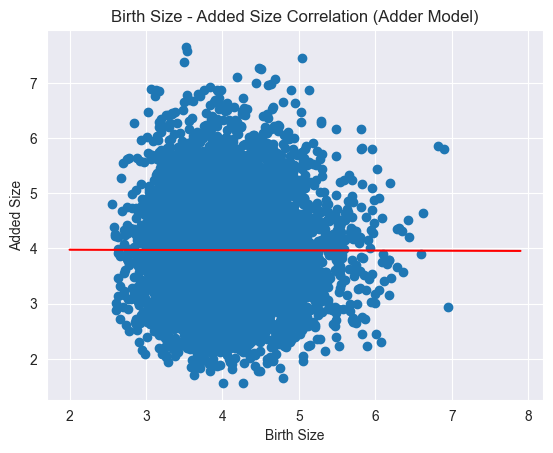

In [59]:
b_size = []
del_size = []
for i in range(ncells):
    idx = find_division(data1, i)
    birth_size = data1.iloc[:, i].to_numpy()[idx[:-1] + 1]
    added_size = data1.iloc[:, i].to_numpy()[idx[1:]] - data1.iloc[:, i].to_numpy()[idx[:-1] + 1]
    b_size.extend(birth_size)
    del_size.extend(added_size)
# slope1, _, __, ___, ____ = linregress(mothers_tau1, daughters_tau1)
slope1, _, __, ___, ____ = linregress(b_size, del_size)
true_lamb = slope1

test_x = np.arange(2, 8, 0.1)
plt.title("Birth Size - Added Size Correlation (Adder Model)")
plt.ylabel("Added Size")
plt.xlabel("Birth Size")
plt.plot(b_size, del_size, 'o')
plt.plot(test_x, slope1 * test_x + _, 'red')
print(1 / (np.mean(np.array(mothers_tau1) / np.array(daughters_tau1))))
print(slope1)
plt.show()

-0.20962314462711595


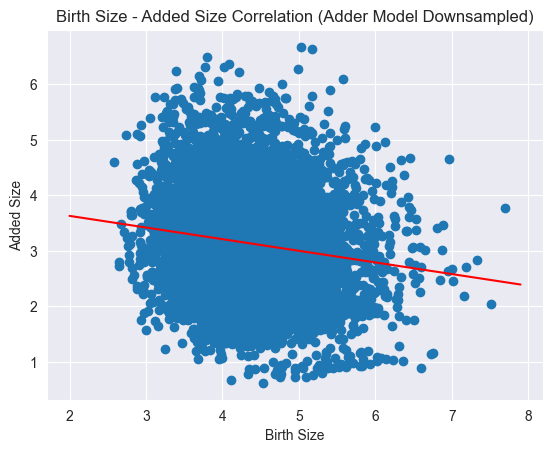

In [71]:
b_size = []
del_size = []
ds = down_sample(data1, n=1000) # 4 min interval
for i in range(ncells):
    idx = find_division(ds, i)
    birth_size = ds.iloc[:, i].to_numpy()[idx[:-1] + 1]
    added_size = ds.iloc[:, i].to_numpy()[idx[1:]] - ds.iloc[:, i].to_numpy()[idx[:-1] + 1]
    b_size.extend(birth_size)
    del_size.extend(added_size)
# slope1, _, __, ___, ____ = linregress(mothers_tau1, daughters_tau1)
slope1, _, __, ___, ____ = linregress(b_size, del_size)

test_x = np.arange(2, 8, 0.1)
plt.title("Birth Size - Added Size Correlation (Adder Model Downsampled)")
plt.ylabel("Added Size")
plt.xlabel("Birth Size")
plt.plot(b_size, del_size, 'o')
plt.plot(test_x, slope1 * test_x + _, 'red')
print(slope1)
plt.show()

In [61]:
time_res = np.arange(1/250, 9, 0.05) # time interval in minutes

errors_t = []
errors_v = []
mean_true = []
var_true = []
mean_est = []
var_est = []
mean2_true = []
var2_true = []
mean2_est = []
var2_est = []
sk_true = []
kur_true = []
sk_est = []
kur_est = []
sk2_true = []
kur2_true = []
sk2_est = []
kur2_est = []

c_est = []
fitness_est = []
lamb_est = []

true_div_times = [x for i in range(ncells) for x in get_prop(data1, i+1)]
for t in time_res:
    
    ds = down_sample(data1, n=round(t*250))
    div_times = [get_prop(ds, i+1) for i in range(ncells)]
    
    bin_number = 50
    
    est_div_times = [item for sublist in div_times for item in sublist]
    m1 = np.mean(true_div_times)
    m2 = np.mean(est_div_times)
    v1 = np.var(true_div_times)
    v2 = np.var(est_div_times)
    mean_true.append(m1)
    mean_est.append(m2)
    var_true.append(v1)
    var_est.append(v2)
    sk_true.append(skew(true_div_times))
    sk_est.append(skew(est_div_times))
    # print(skew(est_div_times) - skew(true_div_times))
    kur_true.append(kurtosis(true_div_times))
    kur_est.append(kurtosis(est_div_times))
    
    mothers_tau = []
    daughters_tau = []
    for sublist in div_times:
        tmother = sublist[:-1]
        tdaughter = sublist[1:]
        mothers_tau.extend(tmother)
        daughters_tau.extend(tdaughter)
    slope, _, __, ___, ____ = linregress(mothers_tau, daughters_tau)
    mother_daughter_c = slope
    c_est.append(mother_daughter_c)
    
    b_size = []
    del_size = []
    for i in range(ncells):
        idx = find_division(ds, i)
        birth_size = ds.iloc[:, i].to_numpy()[idx[:-1] + 1]
        added_size = ds.iloc[:, i].to_numpy()[idx[1:]] - ds.iloc[:, i].to_numpy()[idx[:-1] + 1]
        b_size.extend(birth_size)
        del_size.extend(added_size)
    slope1, _, __, ___, ____ = linregress(b_size, del_size)
    lamb_est.append(slope1)
    
    fitness = 2 * np.log(2) / m2 / (1 + np.sqrt(1 - 2 * np.log(2) * v2 / m2**2 * (1 + mother_daughter_c) / (1 - mother_daughter_c)))
    fitness_est.append(fitness)
    
    count1, bins = np.histogram(np.array(est_div_times), bin_number)
    count2, bins = np.histogram(np.array(true_div_times), bins=bins)
    errors_t.append(sum(abs(count1 - count2)))

1.0


C:\Users\ErezL\AppData\Local\Temp\ipykernel_3168\2928557962.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


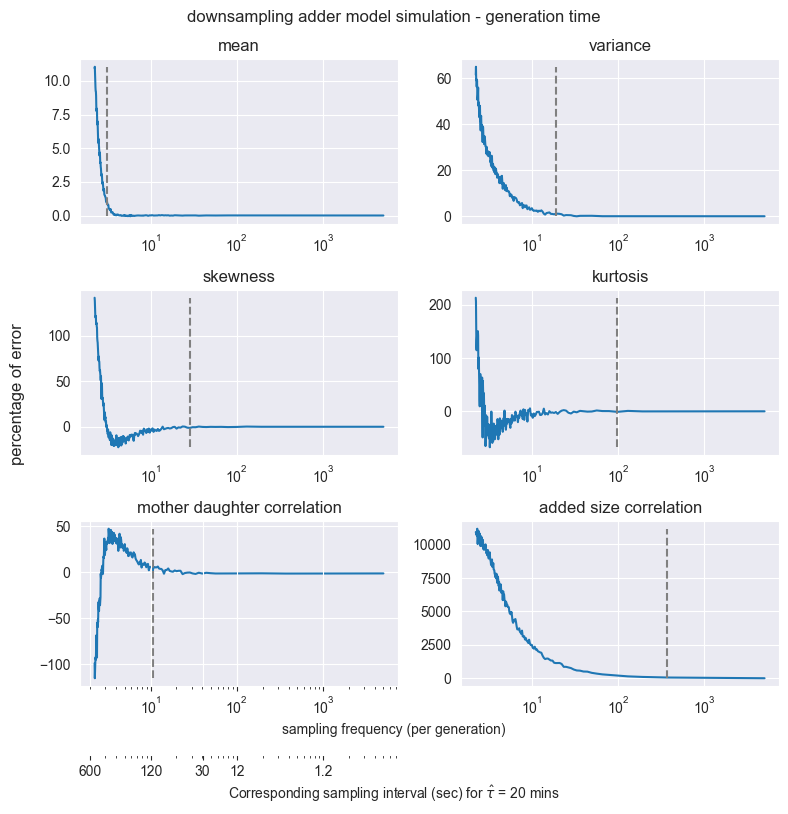

In [62]:
fig = plt.figure(layout="constrained", figsize=(8, 8))
mosaic = """
    0011
    0011
    2233
    2233
    4455
    4455
    """
axes = fig.subplot_mosaic(mosaic)
fig.suptitle("downsampling adder model simulation - generation time")
# axes['0'].plot(mean_true[0]/time_res, mean_est/mean_true[0], label="est")
axes['0'].plot(mean_true[0]/time_res, (mean_est/mean_true[0] - 1)*100, label="est")
axes['0'].set_xscale("log")
idx1 = xunder(abs(mean_est/mean_true[0] - 1), 0.01)
axes['0'].vlines(mean_true[0]/time_res[idx1], min((mean_est/mean_true[0] - 1)*100), max((mean_est/mean_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['0'].set_title("mean")

# axes['1'].plot(mean_true[0]/time_res, var_est/var_true[0], label="est")
axes['1'].plot(mean_true[0]/time_res, (var_est/var_true[0] - 1)*100, label="est")
axes['1'].set_xscale("log")
idx2 = xunder(abs(var_est/var_true[0] - 1), 0.01)
axes['1'].vlines(mean_true[0]/time_res[idx2], min((var_est/var_true[0] - 1)*100), max((var_est/var_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['1'].set_title("variance")

# axes['2'].plot(mean_true[0]/time_res, np.array(sk_est)/sk_true[0], label="est")
axes['2'].plot(mean_true[0]/time_res, (np.array(sk_est)/sk_true[0] - 1)*100, label="est")
print((np.array(sk_est)/sk_true[0])[0])
axes['2'].set_xscale("log")
idx3 = xunder(abs(np.array(sk_est)/sk_est[0] - 1), 0.01, filt=False)
axes['2'].vlines(mean_true[0]/time_res[idx3], min((np.array(sk_est)/sk_true[0] - 1)*100), max((np.array(sk_est)/sk_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['2'].set_title("skewness")

# axes['3'].plot(mean_true[0]/time_res, np.array(kur_est)/kur_true[0], label="est")
axes['3'].plot(mean_true[0]/time_res, (np.array(kur_est)/kur_true[0] - 1)*100, label="est")
axes['3'].set_xscale("log")
idx4 = xunder(abs(np.array(kur_est)/kur_est[0]- 1), 0.01, filt=False)
axes['3'].vlines(mean_true[0]/time_res[idx4], min((np.array(kur_est)/kur_true[0] - 1)*100), max((np.array(kur_est)/kur_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['3'].set_title("kurtosis")

# axes['4'].plot(mean_true[0]/time_res, np.array(c_est)/true_c, label="est")
axes['4'].plot(mean_true[0]/time_res, (np.array(c_est)/true_c - 1)*100, label="est")
axes['4'].set_xscale("log")
idx5 = xunder(abs(np.array(c_est)/true_c - 1), 0.05)
axes['4'].vlines(mean_true[0]/time_res[idx5], min((np.array(c_est)/true_c - 1)*100), max((np.array(c_est)/true_c - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['4'].set_title("mother daughter correlation")

fig.text(0.5, 0.08, 'sampling frequency (per generation)', ha='center', va='center')
fig.supylabel("percentage of error")
fig.text(0.5, 0, r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins', ha='center', va='center')

ax20 = axes['4'].twiny()
ax20.set_xscale("log")
newlabel = [600,120,30,12,1.2] # labels of the xticklabels: the position in the new x-axis
t2f = lambda t: mean_true[0]/(t/60) # convert function: from Kelvin to Degree Celsius
newpos   = [t2f(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax20.set_xticks(newpos)
ax20.set_xticklabels(newlabel)

ax20.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax20.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax20.spines['bottom'].set_position(('outward', 50))
# ax20.set_xlabel(r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins')
ax20.set_xlim(axes['4'].get_xlim())

axes['5'].plot(mean_true[0]/time_res, (np.array(lamb_est)/true_lamb - 1)*100, label="est")
axes['5'].set_xscale("log")
idx5 = xunder(abs(np.array(lamb_est)/true_lamb - 1), 0.05)
axes['5'].vlines(mean_true[0]/time_res[idx5], min((np.array(lamb_est)/true_lamb - 1)*100), max((np.array(lamb_est)/true_lamb - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['5'].set_title("added size correlation")

plt.tight_layout()
plt.show()

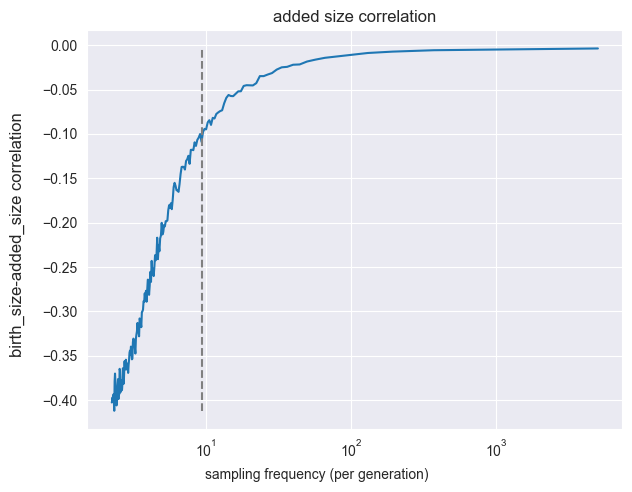

In [77]:
fig, axes = plt.subplots()

fig.text(0.5, 0.0, 'sampling frequency (per generation)', ha='center', va='center')
fig.supylabel("birth_size-added_size correlation")
# fig.text(0.5, 0, r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins', ha='center', va='center')

# ax20 = axes.twiny()
# ax20.set_xscale("log")
# newlabel = [600,120,30,12,1.2] # labels of the xticklabels: the position in the new x-axis
# t2f = lambda t: mean_true[0]/(t/60) # convert function: from Kelvin to Degree Celsius
# newpos   = [t2f(t) for t in newlabel]   # position of the xticklabels in the old x-axis
# ax20.set_xticks(newpos)
# ax20.set_xticklabels(newlabel)
# 
# ax20.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
# ax20.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
# ax20.spines['bottom'].set_position(('outward', 50))
# # ax20.set_xlabel(r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins')
# ax20.set_xlim(axes.get_xlim())

axes.plot(mean_true[0]/time_res, (np.array(lamb_est)), label="est")
axes.set_xscale("log")
idx5 = xunder(abs(np.array(lamb_est)), 0.1)
axes.vlines(mean_true[0]/time_res[idx5], min((np.array(lamb_est))), max((np.array(lamb_est))), 
                 color='0.5', linestyles='dashed')
axes.set_title("added size correlation")

plt.tight_layout()
plt.show()

1.0


C:\Users\ErezL\AppData\Local\Temp\ipykernel_3168\1348930804.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


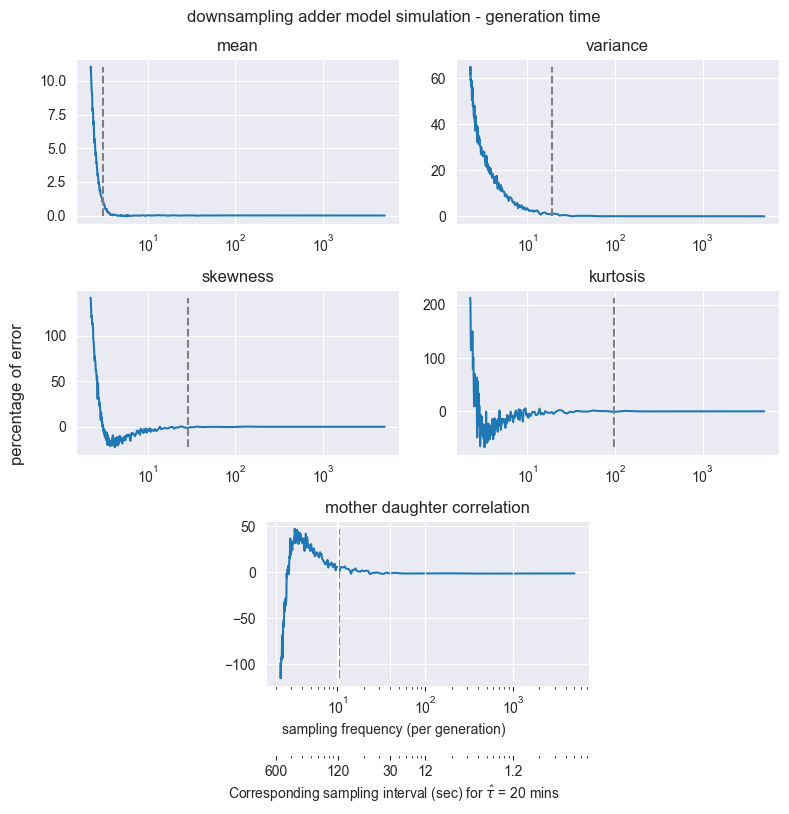

In [51]:
fig = plt.figure(layout="constrained", figsize=(8, 8))
mosaic = """
    0011
    0011
    2233
    2233
    .44.
    .44.
    """
axes = fig.subplot_mosaic(mosaic)
fig.suptitle("downsampling adder model simulation - generation time")
# axes['0'].plot(mean_true[0]/time_res, mean_est/mean_true[0], label="est")
axes['0'].plot(mean_true[0]/time_res, (mean_est/mean_true[0] - 1)*100, label="est")
axes['0'].set_xscale("log")
idx1 = xunder(abs(mean_est/mean_true[0] - 1), 0.01)
axes['0'].vlines(mean_true[0]/time_res[idx1], min((mean_est/mean_true[0] - 1)*100), max((mean_est/mean_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['0'].set_title("mean")

# axes['1'].plot(mean_true[0]/time_res, var_est/var_true[0], label="est")
axes['1'].plot(mean_true[0]/time_res, (var_est/var_true[0] - 1)*100, label="est")
axes['1'].set_xscale("log")
idx2 = xunder(abs(var_est/var_true[0] - 1), 0.01)
axes['1'].vlines(mean_true[0]/time_res[idx2], min((var_est/var_true[0] - 1)*100), max((var_est/var_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['1'].set_title("variance")

# axes['2'].plot(mean_true[0]/time_res, np.array(sk_est)/sk_true[0], label="est")
axes['2'].plot(mean_true[0]/time_res, (np.array(sk_est)/sk_true[0] - 1)*100, label="est")
print((np.array(sk_est)/sk_true[0])[0])
axes['2'].set_xscale("log")
idx3 = xunder(abs(np.array(sk_est)/sk_est[0] - 1), 0.01, filt=False)
axes['2'].vlines(mean_true[0]/time_res[idx3], min((np.array(sk_est)/sk_true[0] - 1)*100), max((np.array(sk_est)/sk_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['2'].set_title("skewness")

# axes['3'].plot(mean_true[0]/time_res, np.array(kur_est)/kur_true[0], label="est")
axes['3'].plot(mean_true[0]/time_res, (np.array(kur_est)/kur_true[0] - 1)*100, label="est")
axes['3'].set_xscale("log")
idx4 = xunder(abs(np.array(kur_est)/kur_est[0]- 1), 0.01, filt=False)
axes['3'].vlines(mean_true[0]/time_res[idx4], min((np.array(kur_est)/kur_true[0] - 1)*100), max((np.array(kur_est)/kur_true[0] - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['3'].set_title("kurtosis")

# axes['4'].plot(mean_true[0]/time_res, np.array(c_est)/true_c, label="est")
axes['4'].plot(mean_true[0]/time_res, (np.array(c_est)/true_c - 1)*100, label="est")
axes['4'].set_xscale("log")
idx5 = xunder(abs(np.array(c_est)/true_c - 1), 0.05)
axes['4'].vlines(mean_true[0]/time_res[idx5], min((np.array(c_est)/true_c - 1)*100), max((np.array(c_est)/true_c - 1)*100), 
                 color='0.5', linestyles='dashed')
axes['4'].set_title("mother daughter correlation")

fig.text(0.5, 0.08, 'sampling frequency (per generation)', ha='center', va='center')
fig.supylabel("percentage of error")
fig.text(0.5, 0, r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins', ha='center', va='center')

ax20 = axes['4'].twiny()
ax20.set_xscale("log")
newlabel = [600,120,30,12,1.2] # labels of the xticklabels: the position in the new x-axis
t2f = lambda t: mean_true[0]/(t/60) # convert function: from Kelvin to Degree Celsius
newpos   = [t2f(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax20.set_xticks(newpos)
ax20.set_xticklabels(newlabel)

ax20.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax20.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax20.spines['bottom'].set_position(('outward', 50))
# ax20.set_xlabel(r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins')
ax20.set_xlim(axes['4'].get_xlim())

plt.tight_layout()
plt.show()

In [56]:
# ncells = 5
# doubling_time = 20 #min
# gr = np.log(2)/doubling_time 
# mean_size = 4 # micron
# div_steps = 20
# 
# tmax = 200 #min
# sample_time = 0.003 #min
# 
# start = time.time()
# sim = Simulator(ncells=ncells, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=None)
# sim.szdyn(tmax=tmax, sample_time=sample_time, nameCRM = "./data/dataAdder.csv")
# print('It took', int(time.time()-start), 'seconds.')

In [57]:
# data2 = pd.read_csv("./data/dataAdder.csv")
# data2_m = data2.melt('time', var_name='cols', value_name='cells')
# # sns.lineplot(data=data1_m, x="time", y="cells", hue='cols')
# sns.lineplot(data=data2_m, x="time", y="cells",  hue='cols')
# plt.show()

In [58]:
# ncells = 1
# doubling_time = 20 #min
# gr = np.log(2)/doubling_time 
# mean_size = 4 # micron
# div_steps = 20
# 
# tmax = 200 #min
# sample_time = 0.003 #min
# 
# start = time.time()
# sim = Simulator(ncells=ncells, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=None)
# sim.divstrat(tmax=tmax, nameDSM = "./data/dataDSM.csv")
# sim.szdyn(tmax=tmax, sample_time=sample_time, nameCRM = "./data/dataAdder.csv")
# print('It took', int(time.time()-start), 'seconds.')

In [59]:
# data3 = pd.read_csv("./data/dataAdder.csv")
# data3_m = data3.melt('time', var_name='cols', value_name='cells')
# # sns.lineplot(data=data1_m, x="time", y="cells", hue='cols')
# sns.lineplot(data=data3_m, x="time", y="cells",  hue='cols')
# plt.show()